In [1]:
from pathlib import Path
from functools import partial
from abc import ABC, abstractmethod
from multiprocessing import Pool

import json
import pickle
import random
import colorsys
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from math import sqrt
from itertools import chain
from collections import Counter, defaultdict, OrderedDict

from IPython.display import display, Image
from IPython.core.display import HTML 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import PIL as pil
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from skimage.restoration import estimate_sigma
from ml_metrics import quadratic_weighted_kappa, rmse

DATA_HOME = Path('../input')
PF_HOME = DATA_HOME / 'petfinder-adoption-prediction'

IS_LOCAL = Path('IS_LOCAL').exists()
LABEL_NUM = 5
FOLDS_NUM = 5

DEFAULT = 999999
pd.set_option('display.max_rows', 30)

print(f'IS_LOCAL = {IS_LOCAL}')

pd.set_option('display.max_columns', None)
SEED = 7
np.random.seed(SEED)
CATEGORY_SUFFIX = '@c'

IS_LOCAL = True


In [2]:
def greedy_group_k_fold_stratified(X, y, groups, k):
    y_counts_per_group = defaultdict(lambda: np.zeros(LABEL_NUM))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(LABEL_NUM))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(LABEL_NUM):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(SEED).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [3]:
def by_indices(data, indices):
        if isinstance(data, pd.DataFrame):
            return data.iloc[indices]
        if isinstance(data, list):
            return [data[i] for i in indices]
        return data[indices]

def explode(df, col, fillna=None):
    ret = None
    
    col_name = col if isinstance(col, str) else '_'.join(col)
    
    new_cols = pd.DataFrame(({f'{col_name}_{k}': v for k, v in d.items()} 
                             for idx, d in df[col].iteritems()))
    if fillna is not None:
        new_cols = new_cols.fillna(fillna)
    new_cols.index = df.index
    
    ret = pd.concat([df, new_cols], axis=1)
    del ret[col]
    return ret

def run_cv_model(
    name, 
    train_y,
    train_x, train_ids,
    test_x, test_ids, 
    reg_model_factory, qwk_model_factory
):
    def format_stats(mean: float, std: float) -> str:
        return f'{mean:.3f} ± {std:.3f}'

    def save_predictions(pred_y):
        if IS_LOCAL:
            preds_dir = Path('predictions')
            preds_path = preds_dir / f'{name}.csv'
            checks_num = 0
            while preds_path.exists():
                checks_num += 1
                new_file_name = f'{name}-{checks_num}.csv'
                preds_path = preds_dir / new_file_name
        else:
            preds_path = 'submission.csv'
        
        print(f'Saving to path `{preds_path}`')

        submission = pd.DataFrame({'PetID': test_ids, 'AdoptionSpeed': pred_y.astype(np.int32)})
        submission.to_csv(preds_path, index=False)
        print(f'Saving successfull')
    
    def get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores):
        data = []
        indices = []
        for fold_ind, scores in enumerate(zip(
            dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores
        )):
            data.append([f'{s:.3f}' for s in scores])
            indices.append(f'{name} - fold {fold_ind}')
        return pd.DataFrame(data, index=indices, columns=[
            'dev cv rmse', 'val cv rmse', 'dev cv qwk', 'val cv qwk'])
    
    def get_distr(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(LABEL_NUM)]

    dev_rmse_scores = []
    dev_qwk_scores = []
    
    val_rmse_scores = []
    val_qwk_scores = []

    pred_train_y_reg = np.zeros(len(train_y))
    pred_test_y_reg = 0
    
    models = []
    qwk_models = []
    
#     splits = StratifiedKFold(n_splits=k, random_state=7, shuffle=True).split(train_x, train_y)
#     splits = GroupKFold(n_splits=k).split(train_x, train_y, groups=train_rescue_ids)
#     splits = group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, FOLDS_NUM)
#     splits = greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, FOLDS_NUM)

    for fold, (dev_indices, val_indices) in enumerate(splits):
        g1 = set(by_indices(train_rescue_ids, dev_indices))
        g2 = set(by_indices(train_rescue_ids, val_indices))
        
        assert len(g1 & g2) == 0
        
        dev_x, val_x = by_indices(train_x, dev_indices), by_indices(train_x, val_indices)
        dev_y, val_y = by_indices(train_y, dev_indices), by_indices(train_y, val_indices)
        dev_ids, val_ids = by_indices(train_ids, dev_indices), by_indices(train_ids, val_indices)
        
        display(pd.DataFrame([
            [f'{len(dev_y) / len(train_y):.2%}'] + get_distr(dev_y),
            [f'{len(val_y) / len(train_y):.2%}'] + get_distr(val_y)
        ], index=[f'fold {fold}: dev_y', f'fold {fold}: val_y'], 
           columns=['# of examples'] + list(range(LABEL_NUM))
        ))

        model = reg_model_factory()
        model.fit(dev_x, dev_ids, dev_y, val_x, val_ids, val_y)
        
        pred_dev_y_reg = model.predict(dev_x, dev_ids, is_train=True)
        dev_rmse_scores.append(rmse(dev_y, pred_dev_y_reg))
        
        pred_val_y_reg = model.predict(val_x, val_ids, is_train=True)
        val_rmse_scores.append(rmse(val_y, pred_val_y_reg))

        qwk_model = qwk_model_factory()
        qwk_model.fit(pred_dev_y_reg, dev_ids, dev_y, pred_val_y_reg, val_ids, val_y)
        
        pred_dev_y = qwk_model.predict(pred_dev_y_reg, dev_ids, is_train=True)
        dev_qwk_scores.append(quadratic_weighted_kappa(dev_y, pred_dev_y))
        
        pred_val_y = qwk_model.predict(pred_val_y_reg, val_ids, is_train=True)
        val_qwk_scores.append(quadratic_weighted_kappa(val_y, pred_val_y))

        pred_train_y_reg[val_indices] = pred_val_y_reg
        pred_test_y_reg += model.predict(test_x, test_ids, is_train=False)
        
        models.append(model)
        qwk_models.append(qwk_model)

    pred_test_y_reg /= FOLDS_NUM

    qwk_model = qwk_model_factory()
    qwk_model = qwk_model.from_models(qwk_models)

    pred_train_y = qwk_model.predict(pred_train_y_reg, train_ids, is_train=True)
    train_qwk = quadratic_weighted_kappa(train_y, pred_train_y)
    
    display(get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores))

    display(pd.DataFrame([[
        '',
        f'{np.mean(dev_rmse_scores):.3f}',
        f'{1.96 * np.std(dev_rmse_scores):.3f}',
        f'{np.mean(val_rmse_scores):.3f}',
        f'{1.96 * np.std(val_rmse_scores):.3f}',
        f'{np.mean(dev_qwk_scores):.3f}',
        f'{1.96 * np.std(dev_qwk_scores):.3f}',
        f'{np.mean(val_qwk_scores):.3f}',
        f'{1.96 * np.std(val_qwk_scores):.3f}',
        f'{train_qwk:.3f}'
    ]], index=[name], columns=[
        'params', 
        'dev cv rmse (avg)', 'dev cv rmse (conf int)', 'val cv rmse (avg)', 'val cv rmse (conf int)',
        'dev cv qwk (avg)', 'dev cv qwk (conf int)', 'val cv qwk (avg)', 'val cv qwk (conf int)', 
        'train set qwk']))
    
    pred_test_y = qwk_model.predict(pred_test_y_reg, test_ids, is_train=False)
    
    display(pd.DataFrame([
        get_distr(train_y),
        get_distr(pred_train_y),
        get_distr(pred_test_y),
    ], index=['train_y', 'pred_train_y', 'pred_test_y'], columns=list(range(LABEL_NUM))))
    
    save_predictions(pred_test_y)
    
    conf_matrix = pd.DataFrame(
        sk_cmatrix(train_y, pred_train_y), index=list(range(LABEL_NUM)), columns=list(range(LABEL_NUM)))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    display(ax)
    
    return OrderedDict([
        ('models',            models),
        ('qwk_models',        qwk_models),
        ('pred_train_y_reg',  pred_train_y_reg),
        ('pred_train_y',      pred_train_y),
        ('pred_test_y_reg',   pred_test_y_reg),
        ('pred_test_y',       pred_test_y),
    ])


def display_train_example(idx):
    data_id = train_ids[idx]
    data = train_x.iloc[idx].to_dict()
    df = pd.DataFrame([
        ('Type', {1: 'dog', 2: 'cat'}[data['Type']]),
        ('Name', data['Name']),
        ('Age', data['Age']),
        ('Breed1', breed_labels_map.get(data['Breed1'], "MISSING")),
        ('Breed2', breed_labels_map.get(data['Breed2'], "MISSING")),
        ('Gender', {1: 'Male', 2: 'Female', 3: 'Mixed'}[data['Gender']]),
        ('Color1', color_labels_map.get(data['Color1'], "MISSING")),
        ('Color2', color_labels_map.get(data['Color2'], "MISSING")),
        ('MaturitySize', {1: 'small', 2: 'medium', 3: 'large', 4: 'extra large', 0: 'NOT SPECIFIED'}[data['MaturitySize']]),
        ('FurLength', {1: 'short', 2: 'medium', 3: 'Long', 0: 'NOT SPECIFIED'}[data['FurLength']]),
        ('Vaccinated', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Vaccinated']]),
        ('Dewormed', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Dewormed']]),
        ('Sterilized', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Sterilized']]),
        ('Health', {1: 'Healthy', 2: 'Minor', 3: 'Serious', 0: 'NOT SPECIFIED'}[data['Health']]),
        ('Quantity', data['Quantity']),
        ('Fee', data['Fee']),
        ('State', state_labels_map[data['State']]),
        ('VideoAmt', data['VideoAmt']),
        ('PhotoAmt', data['PhotoAmt']),
    ], columns=['attribute', 'value'])
    df = df.set_index('attribute')
    display(df)
    display(data['Description'])
    for i in range(1, int(data['PhotoAmt']) + 1):
        display(Image(filename=str(PF_HOME / 'train_images' / f'{data_id}-{i}.jpg')))

def show_random_example(pred_train_y, actual_label, pred_label, n=10):
    indices = [idx for idx, (y, pred_y) in enumerate(zip(train_y, pred_train_y)) 
               if y == actual_label and pred_y == pred_label]
    display_train_example(random.choice(indices))

    
def derive_feature_names(transformer):
    if isinstance(transformer, Pipeline):
        _, t = transformer.steps[-1]
        return derive_feature_names(t)
    elif isinstance(transformer, FeatureUnion):
        return [f'{n}_{f}' for n, t in transformer.transformer_list for f in derive_feature_names(t)]
    try:
        return transformer.get_feature_names()
    except AttributeError:
        raise AttributeError(f'Transformer {transformer} does not have `get_feature_names` function')


def apply_pipeline(pipeline, train_x, test_x):
    train_f = pipeline.fit_transform(train_x)
    test_f = pipeline.transform(test_x)
    feature_names = derive_feature_names(pipeline)
    return train_f, test_f, pipeline, feature_names


def get_categorical_indices(feature_names):
    return [i for i, name in enumerate(feature_names) if name.endswith(CATEGORY_SUFFIX)]

In [4]:
class ColumnSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self._cat_cols = cat_cols
        self._num_cols = num_cols
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        res_X = X[self._cat_cols + self._num_cols]
        res_X.loc[:, self._cat_cols] = X[self._cat_cols].astype('category')
        return res_X


class Mapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, func):
        self._func = func
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        return self._func(X)


class Features(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, transformer, prefix='', categorical=False, feature_names=None):
        self._transformer = transformer
        self._prefix = prefix
        self._categorical_suffix = CATEGORY_SUFFIX if categorical else ''
        if feature_names is not None:
            self._feature_names = self._format_feature_names(feature_names)
            self._features_num = len(feature_names)
        else:
            self._feature_names = None
            self._features_num = None
    
    def fit(self, *args, **kwds):
        self._transformer.fit(*args, **kwds)
        return self
    
    def transform(self, *args, **kwds):
        result = self._transformer.transform(*args, **kwds)
        
        if self._features_num is None:
            self._features_num = self._get_size(result)
        else:
            assert self._features_num == self._get_size(result)
        return result

    def get_feature_names(self):
        if not self._feature_names:
            try:
                fns = self._transformer.get_feature_names()
            except AttributeError:
                if self._features_num is None:
                    raise ValueError('Feature names cannot be taken before calling transform')
                fns = range(self._features_num)
            self._feature_names = self._format_feature_names(fns)
        return self._feature_names
    
    def _format_feature_names(self, feature_names):
        return [f'{self._prefix}{i}{self._categorical_suffix}' for i in feature_names]
    
    def _get_size(self, x):
        if isinstance(x, list) or isinstance(x, pd.Series):
            return len(x[0])
        return x.shape[1]


def Cols(cols, categorical=False):
    return Features(
        Mapper(lambda x: list(zip(*[x[c] for c in cols]))),
        categorical=categorical,
        feature_names=cols
    )

# def CatCols(cols):
#     return Cols(cols, True)


class CatCols(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cols, use_label_encoder=False):
        self._cols = cols
        self._feature_names = [f'{c}{CATEGORY_SUFFIX}' for c in cols]
        
        self._encoders = None
        if use_label_encoder:
            self._encoders = defaultdict(dict)
            
    def fit(self, X, *args, **kwds):        
        return self
    
    def transform(self, X, *args, **kwds):
        col_values = []
        for c in self._cols:
            vals = X[c]
            if self._encoders is not None:
                vals = [self._encode_value(c, v) for v in vals]
            col_values.append(vals)
        return list(zip(*col_values))

    def get_feature_names(self):
        return self._feature_names
    
    def _encode_value(self, col, value):
        try:
            result = self._encoders[col][value]
        except KeyError:
            result = len(self._encoders[col])
            self._encoders[col][value] = result
        return result
        

class Predictor(ABC):
    @abstractmethod
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        pass

    @abstractmethod
    def predict(self, x, ids, is_train):
        pass


class QwkPredictor(Predictor):
    @abstractmethod
    def from_models(self, models):
        pass

In [5]:
class LgbmPredictor(Predictor):
    def __init__(self, params, f_names):
        params = params.copy()
        self.num_rounds = params.pop('num_rounds')
        self.verbose_eval = params.pop('verbose_eval')
        self.early_stop = params.pop('early_stop', None)

        self.params = dict(params)
        self.params['seed'] = SEED
        
        self.model = None
        self._cat_indices = get_categorical_indices(f_names)

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(train_x.shape)
        print(valid_x.shape)
        d_train = lgb.Dataset(train_x, label=train_y, categorical_feature=self._cat_indices)
        d_valid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=self._cat_indices)

        watch_list = [d_train, d_valid]

        self.model = lgb.train(
            self.params,
            train_set=d_train,
            num_boost_round=self.num_rounds,
            valid_sets=watch_list,
            verbose_eval=self.verbose_eval,
            early_stopping_rounds=self.early_stop
        )

    def predict(self, x, ids, is_train):
        return self.model.predict(x, num_iteration=self.model.best_iteration)

    
def display_lgbm_importance(r, f_names, n=100):
    with pd.option_context('display.max_rows', None):
        display(pd.DataFrame(
            Counter(
                dict(zip(f_names, r['models'][0].model.feature_importance('gain')))
            ).most_common(n)
        ))
        

def apply_coeffs(coeffs, x):
    x_p = np.copy(x)
    for i, pred in enumerate(x_p):
        if pred < coeffs[0]:
            x_p[i] = 0
        elif coeffs[0] <= pred < coeffs[1]:
            x_p[i] = 1
        elif coeffs[1] <= pred < coeffs[2]:
            x_p[i] = 2
        elif coeffs[2] <= pred < coeffs[3]:
            x_p[i] = 3
        else:
            x_p[i] = 4
    return x_p


class QwkOptimizer(QwkPredictor):
    def __init__(self):
        self.coefficient = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        assert len(train_x) == len(train_y)
        assert len(valid_x) == len(valid_y)
        loss_partial = partial(self._kappa_loss, x=train_x, y=train_y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coefficient = scipy.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')['x']
        print(f'Coefficients after fitting are {self.coefficient}')

    def predict(self, x, ids, is_train):
        return apply_coeffs(self.coefficient, x)

    def from_models(self, models):
        self.coefficient = np.mean([m.coefficient for m in models], axis=0)
        print(f'Average coefficients taken from models are {self.coefficient}')
        return self

    def _kappa_loss(self, coeffs, x, y):
        x_p = apply_coeffs(coeffs, x)
        return -quadratic_weighted_kappa(y, x_p)

    
class DistributionQwkPredictor(QwkPredictor):
    def __init__(self):
        self.coefficients = None
    
    def fit(self, train_reg, train_ids, train_y, valid_reg, valid_ids, valid_y):
        y_freq = pd.Series(list(valid_y)).value_counts()
        cum_class_distr = [int(y_freq.loc[list(range(i))].sum()) for i in range(1, LABEL_NUM)]
        
        regs = sorted(valid_reg)
        coefficients = []
        for cls_count in cum_class_distr:
            left_reg = regs[cls_count - 1] if cls_count > 0 else regs[0]
            right_reg = regs[cls_count] if cls_count < len(regs) else regs[-1]
            coefficients.append(
                np.mean([left_reg, right_reg])
            )
            
        print(f'Trained coefficients are {coefficients}')
        self.coefficients = np.array(coefficients)

    def predict(self, y_pred_reg, ids, is_train):
        return apply_coeffs(self.coefficients, y_pred_reg)
    
    def from_models(self, models):
        self.coefficients = np.mean([m.coefficients for m in models], axis=0)
        print(f'Average coefficients taken from models are {self.coefficients}')
        return self

    
class TrainingSetDistributionPredictor(QwkPredictor):
    def __init__(self):
        self.coefficient = None
        self.y_freq = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        self.y_freq = pd.Series(list(train_y)).value_counts()

    def predict(self, y_pred_reg, ids, is_train):
        return self._values_to_classes(
            y_pred_reg, self.y_freq
        )
        
    def _values_to_classes(self, ys: np.ndarray, y_freq: pd.Series, verbose=False) -> np.ndarray:
        y_freq = y_freq / y_freq.sum()
        cum_freqs = [y_freq.loc[list(range(i))].sum() for i in range(LABEL_NUM)]
        thresholds = []
        # TODO faster
        for y in sorted(set(ys)):
            fraction = (ys < y).mean()
            if fraction > cum_freqs[len(thresholds) + 1]:
                thresholds.append(y)
                if len(thresholds) == LABEL_NUM - 1:
                    break
        ys_out = np.array([LABEL_NUM - 1] * len(ys), dtype=int)
        for i in reversed(range(LABEL_NUM - 1)):
            ys_out[ys < thresholds[i]] = i
        if verbose:
            logging.info('thresholds: ' +  ' '.join(f'{th:.3f}' for th in thresholds))
        return ys_out
    
    def from_models(self, models):
        self.y_freq = pd.Series(list(np.mean([
            m.y_freq.sort_index() for m in models
        ], axis=0)))
        return self

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm


class PetPyTorchDataset(Dataset):
    def __init__(self, pet_ids, train, y=None, transform=None):
        self.transform = transforms.Compose(transform or [])
        
        image_dir = PF_HOME / ('train_images' if train else 'test_images')
        self.image_paths, data_indices = self._get_image_paths(image_dir, pet_ids)
        
        if y is not None:
            self.y = np.array(by_indices(y, data_indices), dtype=np.float32)
        else: 
            self.y = np.full(len(data_indices), -1, dtype=np.float32)
            
        self.pet_ids = by_indices(pet_ids, data_indices)
        
    def _get_image_paths(self, image_dir, pet_ids, only_first_image=True):
        def get_image_idx(p):
            return int(str(p).rsplit('-', 1)[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        image_paths_per_pet_id = defaultdict(list)
        for p in image_dir.iterdir():
            image_paths_per_pet_id[get_pet_id(p)].append(p)
        
        image_paths = []
        data_indices = []
        for p_index, p_id in enumerate(pet_ids):
            pet_image_paths = sorted(image_paths_per_pet_id[p_id], key=get_image_idx)
            if len(pet_image_paths) > 0 and only_first_image:
                pet_image_paths = [pet_image_paths[0]]
            image_paths.extend(pet_image_paths)
            data_indices.extend([p_index] * len(pet_image_paths))
        
        return image_paths, data_indices
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = pil.Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image), torch.Tensor([self.y[idx]]), self.pet_ids[idx]


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base = models.resnet34(pretrained=False)
        self.base.load_state_dict(self._load_net_state())
        
        last_resnet_size = self.base.fc.in_features
        print(f'Last resnet layer is: {last_resnet_size}')
        
        self.fc = nn.Linear(last_resnet_size * 4, 1)
    
    def _load_net_state(self):
        net_state_path = DATA_HOME / 'resnet34pytorch/resnet34-333f7ec4.pth'
        with net_state_path.open('rb') as in_file:
            return torch.load(in_file)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.base.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

    
class PyTorchModel(Predictor):
    def __init__(self, net, lr, epochs, batch_size, verbose=True):
        self.net = net
        self.lr = lr
        self.epochs = epochs
        self.verbose = verbose
        
        self.batch_size = batch_size
        
        self.transforms = [
            transforms.Resize((256, 256)),
#             transforms.CenterCrop(224),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
        
        device_type = "cuda:0" if torch.cuda.is_available() else "cpu"
        print(f'Device `{device_type}` will be used')
        self.device = torch.device(device_type)
        self.net.to(self.device)
    
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(f'Loading train images for {len(train_ids)} pet ids')
        train_ds = PetPyTorchDataset(train_ids, train=True, y=train_y, transform=self.transforms)
        train_loader = DataLoader(train_ds, shuffle=True, batch_size=self.batch_size)
        
        print(f'Loading valid images for {len(valid_ids)} pet ids')
        valid_ds = PetPyTorchDataset(valid_ids, train=True, y=valid_y, transform=self.transforms)
        valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=self.batch_size)
        
        loss_func = RMSELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        
        best_valid_loss = float('inf')
        best_net_state = None
        
        for epoch in range(self.epochs):
            for x, y, pet_ids in tqdm(train_loader, desc=f'Training (epoch={epoch})', leave=False):
                x = x.to(self.device)
                y = y.to(self.device)
                y_pred = self.net(x)

                loss = loss_func(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                valid_y_pred, valid_y, _ = self._interference(valid_loader)
                valid_loss = loss_func(valid_y_pred, valid_y)

                loss_val = loss.item()
                valid_loss_val = valid_loss.item()

                if self.verbose:
                    print(f'Epoch={epoch}, '
                          f'Batch loss={loss_val}, '
                          f'Valid loss={valid_loss_val}')

                if valid_loss_val < best_valid_loss:
                    best_valid_loss = valid_loss_val
                    best_net_state = self.net.state_dict()

        self.net.load_state_dict(best_net_state)
    
    def _interference(self, loader):
        with torch.no_grad():
            preds_per_batch = []
            y_per_batch = []
            pet_ids = []
            for batch_x, batch_y, batch_pet_ids in tqdm(loader, desc=f'Interference...', leave=False):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                preds = self.net(batch_x)
                preds_per_batch.append(preds)
                y_per_batch.append(batch_y)
                pet_ids.extend(batch_pet_ids)
            return torch.cat(preds_per_batch), torch.cat(y_per_batch), pet_ids

    def predict(self, x, ids, is_train):
        ds = PetPyTorchDataset(ids, train=is_train, transform=self.transforms)
        loader = DataLoader(ds, shuffle=False, batch_size=self.batch_size)
        y_pred, _, inf_ids = self._interference(loader)
        y_pred = y_pred.squeeze(1).cpu().numpy()
        
        preds_per_pet_id = {}
        for pred, pet_id in zip(y_pred, inf_ids):
            assert pet_id not in preds_per_pet_id
            preds_per_pet_id[pet_id] = pred
        
        def random_class():
            return float(np.random.randint(0, LABEL_NUM, dtype='int'))
        
        return np.array([preds_per_pet_id.get(pet_id, random_class()) for pet_id in ids])

In [7]:
def get_idx(p):
    return int(str(p).rsplit('-', 1)[1].split('.')[0])

def replace_missing_with_nan(x):
    if isinstance(x, scipy.sparse.csr_matrix):
        x = x.toarray()
    np.place(x, x == DEFAULT, np.nan)
    return x

def read_data(data_path, shuffle=False):
    X = pd.read_csv(data_path)
    if shuffle:
        X = X.sample(frac=1, random_seed=SEED).reset_index(drop=True)
    try:
        y = list(X.AdoptionSpeed)
    except AttributeError:
        y = None
    ids = list(X.PetID)
#     X.drop(['AdoptionSpeed'], axis=1, inplace=True, errors='ignore')
    return X, y, ids


def read_metadata(pet_ids_list, metadata_dir):
    def extract_label_annotations(metadata_dict):
        def by_score(xs): return xs[1]
        label_annotations = []
        for annotation in metadata_dict.get('labelAnnotations', []):
            desc = annotation['description']
            score = annotation['score']
            label_annotations.append((desc, score))
        return sorted(label_annotations, key=by_score, reverse=True)
    
    def extract_dominant_colors(metadata_dict):
        def by_score(xs): return xs[3]
        dominant_colors = []
        colors = metadata_dict.get('imagePropertiesAnnotation', {}).get('dominantColors', {}).get('colors', [])
        for color_obj in colors:
            rgb_obj = color_obj['color']
            red = rgb_obj.get('red', 0) / 255
            green = rgb_obj.get('green', 0) / 255
            blue = rgb_obj.get('blue', 0) / 255
            score = color_obj['score']
            pixel_fraction = color_obj['pixelFraction']
            dominant_colors.append(
                (red, green, blue, score, pixel_fraction)
            )
        return dominant_colors
    
    def _get_image_paths(image_dir):
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        def get_sorted_photos_by_idx(paths):
            return sorted((get_idx(p), p) for p in paths)
        
        meta_paths_per_pet_id = defaultdict(list)
        for p in image_dir.iterdir():
            pet_id = get_pet_id(p)
            meta_paths_per_pet_id[pet_id].append(p)
        
        return {
            pet_id: get_sorted_photos_by_idx(meta_paths) 
            for pet_id, meta_paths in meta_paths_per_pet_id.items()
        }
    
    image_path_per_pet_id = _get_image_paths(Path(metadata_dir))
    for pet_id in tqdm(pet_ids_list, 'Reading pet ids'):
        pet_metadata_paths = image_path_per_pet_id.get(pet_id, [])
        
        pet_label_annotations = []
        pet_dominant_colors = []
        
        for idx, metadata_path in pet_metadata_paths:
            with metadata_path.open() as in_file:
                metadata_dict = json.load(in_file)
                
                pet_label_annotations.append(extract_label_annotations(metadata_dict))
                pet_dominant_colors.append(extract_dominant_colors(metadata_dict))
        
        yield pet_label_annotations, pet_dominant_colors

In [8]:
def read_sentiment_data(pet_ids_list, sentiment_dir):
    sentiment_dir = Path(sentiment_dir)
    missed_sentiments = 0
    for pet_id in pet_ids_list:
        sentiment_data_path = sentiment_dir / f'{pet_id}.json'
        
        if not sentiment_data_path.exists():
            yield [], {}, DEFAULT, DEFAULT
            missed_sentiments += 1
        else:
            with sentiment_data_path.open() as in_file:
                sentiment_data = json.load(in_file)

                sentence_sents = [(obj['sentiment']['magnitude'], obj['sentiment']['score']) 
                                       for obj in sentiment_data['sentences']]
                entity_sents = {obj['name'].lower().strip(): obj['salience']
                            for obj in sentiment_data['entities']}
                doc_sent_magnitude = sentiment_data['documentSentiment']['magnitude']
                doc_sent_score = sentiment_data['documentSentiment']['score']

                yield sentence_sents, entity_sents, (doc_sent_magnitude, doc_sent_score)
    print(f'Missed sentiment files for {missed_sentiments} pet ids')

def pet_data_assigner(X, data_reader, **mappers):
    extacted_data = defaultdict(list)
    data_num = 0
    errors_per_mapper = Counter()
    for data in data_reader:
        for k, (map_func, default_val) in mappers.items():
            try:
                map_result = map_func(*data)
            except Exception as e:
                map_result = default_val
                errors_per_mapper[k] += 1
            extacted_data[k].append(map_result)
        data_num += 1 
    
    for k, errors_num in errors_per_mapper.items():
        if errors_num > 0: 
            print(f'There were {errors_num} errors ({int(errors_num * 100 / data_num)}%) for mapper {k}')
    
    for k, data in extacted_data.items():
        X[k] = data

        
def train_test_data_assigner(train_data_reader, test_data_reader, **mapper_info):
    mappers = {}
    col_assignments = []
    for k, (mapper_func, default, add_to) in mapper_info.items():
        mappers[k] = (mapper_func, default)
        if add_to is not None:
            col_assignments.append((add_to, k))
    
    pet_data_assigner(
        train_x, train_data_reader, **mappers
    )
    pet_data_assigner(
        test_x, test_data_reader, **mappers
    )
    
    for cols_list, col in col_assignments:
        if col not in cols_list:
            cols_list.append(col)
        
def m(mapper_func, *, default, add_to=None):
    return mapper_func, default, add_to

In [9]:
train_x, train_y, train_ids = read_data(PF_HOME / 'train' / 'train.csv')
test_x, test_y, test_ids = read_data(PF_HOME / 'test' / 'test.csv')

train_rescue_ids = list(train_x['RescuerID'])
splits = list(greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=FOLDS_NUM))

display(train_x.shape)
display(test_x.shape)

special_cols = ['RescuerID', 'PetID', 'AdoptionSpeed']
text_cols = ['Name', 'Description']
num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
cat_cols = list(set(train_x.columns) - set(text_cols) - set(num_cols) - set(special_cols))

breed_labels_map = {row.BreedID: row.BreedName 
                   for _, row in pd.read_csv(PF_HOME / 'breed_labels.csv').iterrows()}

state_labels_map = {row.StateID: row.StateName 
                   for _, row in pd.read_csv(PF_HOME / 'state_labels.csv').iterrows()}

color_labels_map = {row.ColorID: row.ColorName 
                   for _, row in pd.read_csv(PF_HOME / 'color_labels.csv').iterrows()}

# get_breed_rating_map(PF_HOME / 'breed_rating.json')

# breed_rating_map = {k: obj for d in breed_rating.values() for k, obj in d.items()}

# display(len(breed_labels_map))

print(special_cols)
print(text_cols)
print(num_cols)
print(cat_cols)

(14993, 24)

(3948, 23)

['RescuerID', 'PetID', 'AdoptionSpeed']
['Name', 'Description']
['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
['Gender', 'Sterilized', 'Vaccinated', 'Breed2', 'Type', 'Dewormed', 'Color3', 'Color2', 'Breed1', 'State', 'Color1']


In [10]:
def get_map_for_single_type(breed_rating, breed_labels):
    labels = list(breed_rating.keys()) + list(breed_labels.values())
    print(labels)
    
    tfidf = TfidfTransformer()
    tfidf.fit_transform(labels)
    word_to_idf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
    
    print(word_to_idf)
    
    breed_rating_map = {}
    for breed_id, breed_name in breed_labels.items():
        if breed_name in breed_rating:
            breed_rating_map[breed_id] = breed_rating[breed_name]
        else:
            breed_name_idf = {token: word_to_idf[token] for token in breed_name.split()}
            best_idf = None
            best_data = None
            for key, breed_data in breed_rating.items():
                key_idf = {token: word_to_idf[token] for token in key.split()}
                common_tokens = set(breed_name_idf) & set(key_idf)
                

def get_breed_rating_map(breed_rating_path, breed_labels_path):
    breed_labels = pd.read_csv(breed_labels_path)
    
    dog_breed_labels = {row.BreedID: row.BreedName.lower()
                        for _, row in breed_labels.iterrows() if row.Type == 1}
    cat_breed_labels = {row.BreedID: row.BreedName.lower()
                        for _, row in breed_labels.iterrows() if row.Type == 2}
    
    breed_rating = json.loads(breed_rating_path.read_text())
    
    get_map_for_single_type(
        {k.lower(): v for k, v in breed_rating['dog_breeds'].items()}, 
        dog_breed_labels
    )
    
    breed_rating_raw = {k: obj for d in breed_rating.values() for k, obj in d.items()}


    
    
    
    

In [11]:
# get_breed_rating_map(
#     breed_rating_path=PF_HOME/'breed_rating.json', 
#     breed_labels_path=PF_HOME/'breed_labels.csv')

In [12]:
# extract datasets
# https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn
train_img_features = pd.read_csv('../input/extract-image-features-from-pretrained-nn/train_img_features.csv')
test_img_features = pd.read_csv('../input/extract-image-features-from-pretrained-nn/test_img_features.csv')

# img_features columns set names
col_names =["PetID"] + ["{}_img_feature".format(_) for _ in range(256)]
train_img_features.columns = col_names
test_img_features.columns = col_names

train_x = pd.merge(train_x, train_img_features, on="PetID")
test_x = pd.merge(test_x, test_img_features, on="PetID")

num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health'] + [
    "{}_img_feature".format(_) for _ in range(256)]

In [13]:
def merge_la(l_annotations):
    values_per_label = defaultdict(list)
    for annots in l_annotations:
        for label, score in annots:
            values_per_label[label].append(score)
    return {label: np.mean(values) for label, values in values_per_label.items()}

def neg_skew(vals):
    return np.abs(np.max([scipy.stats.skew(vals), 0]))

def pos_skew(vals):
    return np.min([scipy.stats.skew(vals), 0])

def la_vals(la):
    return [val for label, val in la]

def dict_vals(dictionary):
    return list(dictionary.values())

def rms(vals):
    return np.sqrt(np.mean(np.array(vals)))

In [14]:
train_test_data_assigner(
    read_sentiment_data(train_ids, PF_HOME / 'train_sentiment'),
    read_sentiment_data(test_ids, PF_HOME / 'test_sentiment'),
    first_sentence_magnitude=     m(lambda ss, es, ds: ss[0][0], default=DEFAULT, add_to=num_cols),
    first_sentence_score=         m(lambda ss, es, ds: ss[0][1], default=DEFAULT, add_to=num_cols),
    second_sentence_magnitude=    m(lambda ss, es, ds: ss[1][0], default=DEFAULT, add_to=num_cols),
    second_sentence_score=        m(lambda ss, es, ds: ss[1][1], default=DEFAULT, add_to=num_cols),
    third_sentence_magnitude=     m(lambda ss, es, ds: ss[2][0], default=DEFAULT, add_to=num_cols),
    third_sentence_score=         m(lambda ss, es, ds: ss[2][1], default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MIN=       m(lambda ss, es, ds: np.min([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MAX=       m(lambda ss, es, ds: np.max([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MEDIAN=    m(lambda ss, es, ds: np.median([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MEAN=      m(lambda ss, es, ds: np.mean([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_STD=       m(lambda ss, es, ds: np.std([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_RMS=       m(lambda ss, es, ds: rms([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_KURTOSIS=  m(lambda ss, es, ds: scipy.stats.kurtosis([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_NEG_SKEW=  m(lambda ss, es, ds: neg_skew([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_POS_SKEW=  m(lambda ss, es, ds: pos_skew([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MIN=       m(lambda ss, es, ds: np.min([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MAX=       m(lambda ss, es, ds: np.max([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MEDIAN=    m(lambda ss, es, ds: np.median([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MEAN=      m(lambda ss, es, ds: np.mean([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_STD=       m(lambda ss, es, ds: np.std([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_RMS=       m(lambda ss, es, ds: rms([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_KURTOSIS=  m(lambda ss, es, ds: scipy.stats.kurtosis([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_NEG_SKEW=  m(lambda ss, es, ds: neg_skew([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_POS_SKEW=  m(lambda ss, es, ds: pos_skew([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_count=               m(lambda ss, es, ds: len(ss), default=DEFAULT, add_to=num_cols),
    entity_sents=                 m(lambda ss, es, ds: es, default={}),
    doc_sent_magnitude=           m(lambda ss, es, ds: ds[0], default=DEFAULT, add_to=num_cols),
    doc_sent_score=               m(lambda ss, es, ds: ds[1], default=DEFAULT, add_to=num_cols),
)

/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


Missed sentiment files for 551 pet ids
There were 5074 errors (33%) for mapper third_sentence_magnitude
There were 5074 errors (33%) for mapper third_sentence_score
There were 3161 errors (21%) for mapper second_sentence_magnitude
There were 3161 errors (21%) for mapper second_sentence_score
There were 551 errors (3%) for mapper first_sentence_magnitude
There were 551 errors (3%) for mapper first_sentence_score
There were 551 errors (3%) for mapper sentence_magnitude_MIN
There were 551 errors (3%) for mapper sentence_magnitude_MAX
There were 551 errors (3%) for mapper sentence_magnitude_MEDIAN
There were 551 errors (3%) for mapper sentence_magnitude_MEAN
There were 551 errors (3%) for mapper sentence_magnitude_STD
There were 551 errors (3%) for mapper sentence_magnitude_RMS
There were 551 errors (3%) for mapper sentence_magnitude_KURTOSIS
There were 551 errors (3%) for mapper sentence_magnitude_NEG_SKEW
There were 551 errors (3%) for mapper sentence_magnitude_POS_SKEW
There were 551 er

In [15]:
train_test_data_assigner(
    read_metadata(train_ids, PF_HOME / 'train_metadata'),
    read_metadata(test_ids, PF_HOME / 'test_metadata'),
    first_img_la=     m(lambda la, dm: dict(la[0]), default={}),
    first_img_la_score_MIN=    m(lambda la, dm: np.min(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_MAX=    m(lambda la, dm: np.max(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_MEDIAN= m(lambda la, dm: np.median(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_MEAN=   m(lambda la, dm: np.mean(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_STD=    m(lambda la, dm: np.std(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_RMS=    m(lambda la, dm: rms(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_NEG_SKEW=    m(lambda la, dm: neg_skew(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_POS_SKEW=    m(lambda la, dm: pos_skew(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    all_imgs_la=    m(lambda la, dm: merge_la(la), default={}),
    all_imgs_la_score_MIN=    m(lambda la, dm: np.min(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_MAX=    m(lambda la, dm: np.max(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_MEDIAN= m(lambda la, dm: np.median(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_MEAN=   m(lambda la, dm: np.mean(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_STD=    m(lambda la, dm: np.std(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_RMS=    m(lambda la, dm: rms(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_NEG_SKEW=    m(lambda la, dm: neg_skew(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_POS_SKEW=    m(lambda la, dm: pos_skew(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MIN=    m(lambda la, dm: np.min([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MAX=    m(lambda la, dm: np.max([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MEDIAN= m(lambda la, dm: np.median([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MEAN=    m(lambda la, dm: np.mean([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_STD=    m(lambda la, dm: np.std([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_RMS=    m(lambda la, dm: rms([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_NEG_SKEW=    m(lambda la, dm: neg_skew([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_POS_SKEW=    m(lambda la, dm: pos_skew([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MIN=    m(lambda la, dm: np.min([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MAX=    m(lambda la, dm: np.max([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MEDIAN=    m(lambda la, dm: np.median([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MEAN=    m(lambda la, dm: np.mean([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_STD=    m(lambda la, dm: np.std([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_RMS=    m(lambda la, dm: rms([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_NEG_SKEW=    m(lambda la, dm: neg_skew([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_POS_SKEW=    m(lambda la, dm: pos_skew([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MIN=    m(lambda la, dm: np.min([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MAX=    m(lambda la, dm: np.max([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MEDIAN=    m(lambda la, dm: np.median([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MEAN=    m(lambda la, dm: np.mean([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_STD=    m(lambda la, dm: np.std([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_RMS=    m(lambda la, dm: rms([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_KURTOSIS=   m(lambda la, dm: scipy.stats.kurtosis([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_NEG_SKEW=   m(lambda la, dm: neg_skew([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_POS_SKEW=   m(lambda la, dm: pos_skew([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MIN=         m(lambda la, dm: np.min([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MAX=         m(lambda la, dm: np.max([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MEDIAN=      m(lambda la, dm: np.median([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MEAN=        m(lambda la, dm: np.mean([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_STD=         m(lambda la, dm: np.std([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_RMS=         m(lambda la, dm: rms([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_NEG_SKEW=    m(lambda la, dm: neg_skew([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_POS_SKEW=    m(lambda la, dm: pos_skew([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
)

/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp


There were 341 errors (2%) for mapper first_img_la
There were 343 errors (2%) for mapper first_img_la_score_MIN
There were 343 errors (2%) for mapper first_img_la_score_MAX
There were 341 errors (2%) for mapper first_img_la_score_MEDIAN
There were 341 errors (2%) for mapper first_img_la_score_MEAN
There were 341 errors (2%) for mapper first_img_la_score_STD
There were 341 errors (2%) for mapper first_img_la_score_RMS
There were 341 errors (2%) for mapper first_img_la_score_KURTOSIS
There were 341 errors (2%) for mapper first_img_la_score_NEG_SKEW
There were 341 errors (2%) for mapper first_img_la_score_POS_SKEW
There were 341 errors (2%) for mapper all_imgs_la_score_MIN
There were 341 errors (2%) for mapper all_imgs_la_score_MAX
There were 341 errors (2%) for mapper first_img_dm_score_MIN
There were 341 errors (2%) for mapper first_img_dm_score_MAX
There were 341 errors (2%) for mapper first_img_dm_score_MEDIAN
There were 341 errors (2%) for mapper first_img_dm_score_MEAN
There were 3


There were 127 errors (3%) for mapper first_img_la
There were 127 errors (3%) for mapper first_img_la_score_MIN
There were 127 errors (3%) for mapper first_img_la_score_MAX
There were 127 errors (3%) for mapper first_img_la_score_MEDIAN
There were 127 errors (3%) for mapper first_img_la_score_MEAN
There were 127 errors (3%) for mapper first_img_la_score_STD
There were 127 errors (3%) for mapper first_img_la_score_RMS
There were 127 errors (3%) for mapper first_img_la_score_KURTOSIS
There were 127 errors (3%) for mapper first_img_la_score_NEG_SKEW
There were 127 errors (3%) for mapper first_img_la_score_POS_SKEW
There were 127 errors (3%) for mapper all_imgs_la_score_MIN
There were 127 errors (3%) for mapper all_imgs_la_score_MAX
There were 127 errors (3%) for mapper first_img_dm_score_MIN
There were 127 errors (3%) for mapper first_img_dm_score_MAX
There were 127 errors (3%) for mapper first_img_dm_score_MEDIAN
There were 127 errors (3%) for mapper first_img_dm_score_MEAN
There were 1

In [16]:
class TextFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, prefix=''):
        self._prefix = prefix
    
    def transform(self, texts, *_):
        return [self._text_features(t) for t in texts]
    
    def _text_features(self, text):
        tokens = nltk.word_tokenize(text)
        token_sizes = list(map(len, tokens))
        
        return [
            len(text),
            len(tokens),
            np.min(token_sizes) if token_sizes else DEFAULT,
            np.max(token_sizes) if token_sizes else DEFAULT,
            np.median(token_sizes) if token_sizes else DEFAULT,
            np.mean(token_sizes) if token_sizes else DEFAULT,
            np.std(token_sizes) if token_sizes else DEFAULT,
            rms(token_sizes) if token_sizes else DEFAULT,
            scipy.stats.kurtosis(token_sizes) if token_sizes else DEFAULT,
            neg_skew(token_sizes) if token_sizes else DEFAULT,
            pos_skew(token_sizes) if token_sizes else DEFAULT,
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        return [f'{self._prefix}{n}' for n in [
            'text_len', 'tokens_num', 'token_size_MIN', 'token_size_MAX', 'token_size_MEDIAN', 
            'token_size_MEAN', 'token_size_STD', 'token_size_RMS', 'token_size_KURTOSIS',
            'token_size_NEG_SKEW', 'token_size_POS_SKEW',
        ]]

In [17]:
img_converters = [
    lambda img: img.convert('RGB'),
    lambda img: img.convert('HSV'),
    lambda img: img.convert('L'),
]

stats_funcs = [
    np.min,
    np.max,
    np.median,
    np.mean,
    np.std,
    lambda xs, axis: np.sqrt(np.mean(xs**2, axis=axis)),
    lambda xs, axis: scipy.stats.kurtosis(xs, axis=axis, fisher=False),
    lambda xs, axis: np.abs(scipy.stats.skew(xs, axis=axis).clip(max=0)),
    lambda xs, axis: scipy.stats.skew(xs, axis=axis).clip(min=0),
]

class ImgFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, img_no, *img_directories):
        self.image_path_per_pet_id = {}
        for img_dir in tqdm(img_directories, desc='Reading image paths'):
            self.image_path_per_pet_id.update(
                self._get_image_paths(img_dir, img_no)
            )
        self.feature_prefix = f'image{img_no}_'
        self.channels_num = 7
    
    def transform(self, pet_ids, *_):
        with Pool(processes=None) as pool:
            return [img_f for img_f in pool.imap(
                self._extract_img_features,
                tqdm(pet_ids, desc='Transforming images...'),
                chunksize=2**8
            )]
    
    def _extract_img_features(self, pet_id):
        img_path = self.image_path_per_pet_id.get(pet_id, None)
        img = pil.Image.open(img_path) if img_path else None
        
        img_features = []
        img_features.extend(self._compute_img_size_features(img))
        img_features.extend(self._compute_img_color_features(img))
        img_features.extend(self._compute_noisiness_estimate(img))
        
        return img_features
    
    def _compute_img_size_features(self, img):
        return [
            img.width if img is not None else DEFAULT,
            img.height if img is not None else DEFAULT,
            img.width / img.height if img is not None else DEFAULT,
            img.width * img.height if img is not None else DEFAULT,
        ]
    
    def _compute_img_color_features(self, img):
        def get_default():
            return [DEFAULT] * self.channels_num * len(stats_funcs)
        
        if img is None:
            return get_default()
        
        try:
            converted_imgs = [np.array(conv(img)).reshape(np.product(img.size), -1)
                              for conv in img_converters]
            img_colors = np.hstack(converted_imgs)

            img_color_features = []
            for func in stats_funcs:
                img_color_features.extend(
                    func(img_colors, axis=0)
                )
            return img_color_features
        except ValueError:
            return get_default()
    
    def _compute_noisiness_estimate(self, img):
        return [
            estimate_sigma(np.array(img.convert('L'))) if img is not None else DEFAULT
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        f_names = [
            'width', 'height', 'aspect_ratio', 'resolution'
        ]
        for s in ['min', 'max', 'median', 'mean', 'std', 'rms', 'kurtosis', 'neg_skew', 'pos_skew']:
            for c in ['r', 'g', 'b', 'h', 's', 'v', 'grey']:
                f_names.append(f'color_{s}_{c}')
        f_names.append('noisiness')
        
        return [f'{self.feature_prefix}{n}' for n in f_names]
    
    def _get_image_paths(self, image_dir, img_no):
        def get_image_idx(p):
            return int(str(p).rsplit('-', 1)[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        return {get_pet_id(p): p for p in image_dir.iterdir() if get_image_idx(p) == img_no}

In [18]:
class RescuerFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, num_cols, cat_cols, rescued_id_col='RescuerID'):
        self._num_cols = num_cols
        self._cat_cols = cat_cols
        self._rescued_id_col = rescued_id_col
        
        self.columns = None
    
    def transform(self, df, *_):
        result = self._extract_rescuer_features(df)
        for c in self.columns:
            if c not in result.columns:
                result[c] = np.full(df.shape[0], DEFAULT)
        return result[self.columns]
    
    def fit(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return self
    
    def fit_transform(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return df
    
    def get_feature_names(self):
        if self.columns is None:
            raise ValueError('RescuerFeatures was not fitted')
        return self.columns
    
    def _extract_rescuer_features(self, df):
        def num_col_features(values):
            values = list(values)
            return dict(
                min=np.min(values) if values else DEFAULT,
                max=np.max(values) if values else DEFAULT,
                median=np.median(values) if values else DEFAULT,
                mean=np.mean(values) if values else DEFAULT,
                std=np.std(values) if values else DEFAULT,
                rms=rms(values) if values else DEFAULT,
                kurtosis=scipy.stats.kurtosis(values) if values else DEFAULT,
                neg_skew=neg_skew(values) if values else DEFAULT,
                pos_skew=pos_skew(values) if values else DEFAULT,
            )
        
        def cat_col_features(values):
            return Counter(values)
        
        agg_operations = defaultdict(list)
        for c in self._num_cols:
            agg_operations[c].append(num_col_features)
        for c in self._cat_cols:
            agg_operations[c].append(cat_col_features)
        agg_operations[self._rescued_id_col].append('size')
            
        by_rescuer_id = df.groupby(self._rescued_id_col).agg(agg_operations)
        for outer_c, inner_c in by_rescuer_id.columns:
            if inner_c in {'num_col_features', 'cat_col_features'}:
                by_rescuer_id = explode(by_rescuer_id, (outer_c, inner_c), DEFAULT)
        by_rescuer_id.columns = [c if isinstance(c, str) else '_'.join(c) 
                                 for c in by_rescuer_id.columns]
        
        result = df[[self._rescued_id_col]].merge(
            by_rescuer_id, how='outer', left_on=self._rescued_id_col, right_index=True
        ).sort_index()
        result.drop(self._rescued_id_col, axis=1, inplace=True)
        return result

In [19]:
agg_functions = [
#     np.min,
#     np.max,
    pd.DataFrame.median,
    pd.DataFrame.mean,
    pd.DataFrame.std,
    pd.DataFrame.kurt,
    pd.DataFrame.skew,
]


class TargetEncoding(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, target_col, feature_cols):
        self._target_col = target_col
        self._feature_cols = feature_cols
        
        self._out_f_names = None
        
        self.target_coding_map = None
    
    def transform(self, x, *_):
        result = pd.DataFrame(index=x.index)
        for f_col in tqdm(self._feature_cols, desc='Transform in target encoding'):
            mapping, default_vals = self.target_coding_map[f_col]
            
            df_to_append = mapping.reindex(x[f_col])
            df_to_append.fillna(value=default_vals, inplace=True)
            df_to_append.columns = [f'{f_col}_{c.upper()}' for c in df_to_append.columns]
            df_to_append.index = x.index
            
            result = pd.concat([result, df_to_append], axis=1)
        return result
    
    def fit(self, x, y, *_):
        raise ValueError('Fit cannot be used')
    
    def fit_transform(self, x, y, *_):
        target_coding_map = {}
        result = pd.DataFrame(index=x.index)
        for f_col in tqdm(self._feature_cols, desc='Fit-transform in target encoding'):
            df_to_append, mapping, default_vals = self._target_coding(x, f_col, self._target_col)
            df_to_append.columns = [f'{f_col}_{c.upper()}' for c in df_to_append.columns]
            result = pd.concat([result, df_to_append], axis=1)
            target_coding_map[f_col] = (mapping, default_vals)
        self.target_coding_map = target_coding_map
        
        self._out_f_names = result.columns
        
        return result
    
    def get_feature_names(self):
        return self._out_f_names
        
    def _target_coding(self, data, feature, target='y'):
        def concat_dfs(dfs):
            out_df = pd.concat(dfs)
            return out_df.groupby(out_df.index).mean()
        
        uniq_vals = list(data[feature].unique())

        oof_default_vals = data[target].agg(agg_functions)
        target_coded = pd.DataFrame(dict(oof_default_vals), index=data.index)
        
        oof_mean_cv_to_concat = []
        for infold, oof in splits:
            kf_inner = KFold(n_splits=10, shuffle=True)
            inner_oof_mean_cv_to_concat = []
            
            try:
                inner_splits = list(kf_inner.split(data.iloc[infold]))
            except ValueError:
                inner_oof_mean_cv = pd.DataFrame(
                    dict(oof_default_vals),
                    index=uniq_vals
                )
            else:
                oof_default_infold_mean = data.iloc[infold][target].agg(agg_functions)
                for infold_inner, oof_inner in inner_splits:
                    oof_mean = pd.DataFrame(
                        data.iloc[infold_inner].groupby(by=feature)[target].agg(agg_functions),
                        index=uniq_vals
                    )
                    oof_mean.fillna(value=oof_default_infold_mean, inplace=True)
                    inner_oof_mean_cv_to_concat.append(oof_mean)

                inner_oof_mean_cv = concat_dfs(inner_oof_mean_cv_to_concat)
                inner_oof_mean_cv.fillna(value=oof_default_vals, inplace=True)

            oof_mean_cv_to_concat.append(inner_oof_mean_cv)

            to_assign = inner_oof_mean_cv.loc[data.iloc[oof][feature]]
            to_assign.index = oof
            target_coded.iloc[oof] = to_assign
        
        oof_mean_cv = concat_dfs(oof_mean_cv_to_concat)
        oof_mean_cv.fillna(value=oof_default_vals, inplace=True)

        return target_coded, oof_mean_cv, oof_default_vals

In [22]:
train_f, test_f, p, f_names = apply_pipeline(make_pipeline(
    FeatureUnion([
        ('desc_tokenizing', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            CountVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                dtype=np.float32
            ),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
                ('nmf', Features(NMF(n_components=4, random_state=SEED))),
            ])
        )),
        ('desc_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            TextFeatures('desc_')
        )),
        ('name_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Name.fillna(''))),
            TextFeatures('name_')
        )),
        ('num_cols', Cols(num_cols)),
        ('cat_cols', CatCols(cat_cols, use_label_encoder=True)),
        ('target_encoded', TargetEncoding('AdoptionSpeed', cat_cols)),
        ('rescuer_fs', make_pipeline(
            RescuerFeatures(num_cols=num_cols, cat_cols=[]),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=120, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=4, random_state=SEED))),
#             ])
        )),
        ('entity_sents', make_pipeline(
            Mapper(lambda x: x.entity_sents),
            DictVectorizer(),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
                ('nmf', Features(NMF(n_components=4, random_state=SEED)))
            ])
        )),
        ('img_annotations_first_img', make_pipeline(
            Mapper(lambda x: x.first_img_la),
            DictVectorizer(),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
#             ])
        )),
        ('img_annotations_all_imgs', make_pipeline(
            Mapper(lambda x: x.all_imgs_la),
            DictVectorizer(),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
#             ])
        )),
        ('img1_fs', make_pipeline(
            Mapper(lambda x: x.PetID),
            ImgFeatures(1, PF_HOME / 'train_images', PF_HOME / 'test_images'),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=4, random_state=SEED))),
#             ])
        )),
        ('img2_fs', make_pipeline(
            Mapper(lambda x: x.PetID),
            ImgFeatures(2, PF_HOME / 'train_images', PF_HOME / 'test_images'),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=4, random_state=SEED))),
#             ])
        )),
        ('img3_fs', make_pipeline(
            Mapper(lambda x: x.PetID),
            ImgFeatures(3, PF_HOME / 'train_images', PF_HOME / 'test_images'),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=4, random_state=SEED))),
#             ])
        )),
    ])
), train_x, test_x)

/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/lib/function_base.py:3400: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/lib/function_base.py:3400: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [23]:
with open('features_more.pickle', 'wb') as handle:
    pickle.dump(
        (train_y, train_f, train_ids, test_f, test_ids, f_names), 
        handle
    )

# with open('features.pickle', 'rb') as handle:
#     train_y, train_f, train_ids, test_f, test_ids, f_names = pickle.load(handle)

,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 5889)
(3005, 5889)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.758252	valid_1's rmse: 1.04586
[1000]	training's rmse: 0.624215	valid_1's rmse: 1.04252
[1500]	training's rmse: 0.527834	valid_1's rmse: 1.04295
[2000]	training's rmse: 0.447743	valid_1's rmse: 1.0434
Early stopping, best iteration is:
[1200]	training's rmse: 0.583235	valid_1's rmse: 1.04227
Trained coefficients are [1.645762195896331, 2.1238246007235375, 2.473764714648191, 2.79782065933623]


,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 5889)
(2994, 5889)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.751148	valid_1's rmse: 1.0451
[1000]	training's rmse: 0.620611	valid_1's rmse: 1.04286
[1500]	training's rmse: 0.52076	valid_1's rmse: 1.04374
Early stopping, best iteration is:
[785]	training's rmse: 0.670482	valid_1's rmse: 1.04255
Trained coefficients are [1.599956189478843, 2.113088009016818, 2.4970462215288878, 2.8388433716533514]


,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 5889)
(2994, 5889)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.754441	valid_1's rmse: 1.04392
[1000]	training's rmse: 0.631088	valid_1's rmse: 1.04161
[1500]	training's rmse: 0.533751	valid_1's rmse: 1.04279
Early stopping, best iteration is:
[932]	training's rmse: 0.645605	valid_1's rmse: 1.04152
Trained coefficients are [1.4329425767371422, 2.0359667723097226, 2.4444603850253066, 2.80554221372973]


,# of examples,0,1,2,3,4
fold 3: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 5889)
(3004, 5889)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.75046	valid_1's rmse: 1.05221
[1000]	training's rmse: 0.62114	valid_1's rmse: 1.05088
[1500]	training's rmse: 0.524119	valid_1's rmse: 1.05187
Early stopping, best iteration is:
[743]	training's rmse: 0.68262	valid_1's rmse: 1.05051
Trained coefficients are [1.6499342912413941, 2.1062513766889577, 2.4339687416329117, 2.7775147050215936]


,# of examples,0,1,2,3,4
fold 4: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 5889)
(2996, 5889)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	training's rmse: 0.751779	valid_1's rmse: 1.03636
[1000]	training's rmse: 0.625856	valid_1's rmse: 1.03424
[1500]	training's rmse: 0.531968	valid_1's rmse: 1.03473
Early stopping, best iteration is:
[877]	training's rmse: 0.651726	valid_1's rmse: 1.03346
Trained coefficients are [1.682566753041646, 2.169933460456557, 2.5743130378861356, 2.9125955771917935]
Average coefficients taken from models are [1.6022324  2.10981284 2.48471062 2.82646331]


,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.583,1.042,0.852,0.447
lgbm - fold 1,0.670,1.043,0.831,0.457
lgbm - fold 2,0.646,1.042,0.847,0.450
lgbm - fold 3,0.683,1.051,0.817,0.425
lgbm - fold 4,0.652,1.033,0.829,0.473


,params,dev cv rmse (avg),dev cv rmse (conf int),val cv rmse (avg),val cv rmse (conf int),dev cv qwk (avg),dev cv qwk (conf int),val cv qwk (avg),val cv qwk (conf int),train set qwk
lgbm,,0.647,0.067,1.042,0.011,0.835,0.025,0.451,0.030,0.451


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.93%,20.30%,26.96%,21.63%,28.19%
pred_test_y,2.08%,22.85%,25.35%,21.53%,28.19%


Saving to path `predictions/lgbm-2.csv`
Saving successfull


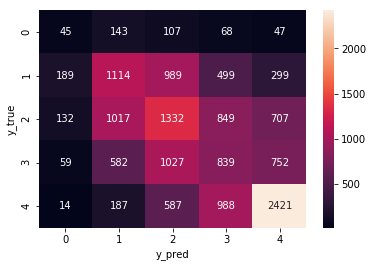

In [24]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 280,
    'max_depth': 11,
    'learning_rate': 0.01,
    'bagging_fraction': 0.5,
    'feature_fraction': 0.5,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 1000,
    'verbose_eval': 500,
    'num_rounds': 20000,
}



results = run_cv_model(
    'lgbm', 
    train_y,
#     replace_missing_with_nan(train_f), train_ids, 
#     replace_missing_with_nan(test_f), test_ids, 
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: DistributionQwkPredictor()
)

In [ ]:
# display_lgbm_importance(results, f_names, 3000)

In [ ]:
# show_random_example(results['pred_train_y'], actual_label=4, pred_label=2)